In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import snntorch
import snntorch.functional

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean, stdev
from sklearn.metrics import confusion_matrix, accuracy_score
from importnb import Notebook
import tqdm
import copy
import collections

In [2]:
with Notebook():
    from Preprocessing import *

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
data = data.to(device)
labels = labels.to(device)
subjects = subjects.to(device)

In [4]:
data.shape, labels.shape, subjects.shape

(torch.Size([9315, 6, 4096]), torch.Size([9315, 3]), torch.Size([9315]))

In [5]:
def segment(data, labels, subjects, size=1024, hop=512):
    '''Segment the data into smaller portions to enable "more" trials per subject. 
    The idea being that the training would be more stable.'''
    segments = []
    for start in range(0, data.size(2) - size + 1, hop):
        segments.append(data[:, :, start:start + size])  
    data = torch.cat(segments, dim=0)
    labels = labels.repeat_interleave(len(segments), dim=0)
    subjects = subjects.repeat_interleave(len(segments), dim=0)
    return data, labels, subjects

In [6]:
#data, labels, subjects = segment(data, labels, subjects)

In [7]:
data.shape, labels.shape, subjects.shape

(torch.Size([9315, 6, 4096]), torch.Size([9315, 3]), torch.Size([9315]))

In [8]:
ratios = (8, 16, 32, 64, 128)
components_by_ratio = {}
filtered_data = None
for ratio in tqdm.tqdm(ratios, unit="ratio"):
    path = f"components_{ratio}.pt"
    if os.path.exists(path):
        components_by_ratio[ratio] = torch.load(path, weights_only=True).to(device)
    else:
        if filtered_data is None:
            filtered_data = bandpass_filter(robust_scaler(data.to("cpu")))
        components_by_ratio[ratio] = normalize(ica(downsample(filtered_data, 1024, 1024 // ratio))).to(device)
        torch.save(components_by_ratio[ratio].cpu(), path)

100%|██████████| 5/5 [00:00<00:00, 37.33ratio/s]


In [29]:
best_params = {'ratio': 8,
 'batch_size': 9,
 'hidden_size': 40,
 'layers': 5,
 'epochs': 30,
 'gain': 0.56,
 'bias': 0.88,
 'lr': 0.001,
 'delta': 0.125}

best_params = {
    'ratio': 128,
 'batch_size': 15,
 'hidden_size': 82,
 'layers': 4,
 'epochs': 100,
 'gain': 0.7251851945260003,
 'bias': 0.29166474317678237,
 'lr': 0.0009282039327593753,
 'delta': 0.025635045347033366
}

# Turn the output from optuna into local variables...
for key, value in best_params.items():
    locals()[key] = value

subjects_count = 15
ensamble_count = 5
runs = 5

In [30]:
components = components_by_ratio[ratio]
classes = labels[:, 1]

In [31]:
components.shape, classes.shape

(torch.Size([9315, 6, 32]), torch.Size([9315]))

In [32]:
mask1 = labels[:, 0] == modalities.index("Imagined")
mask2 = labels[:, 2] == artifacts.index("None")
mask3 = labels[:, 1] <= stimuli.index("U")

# Include artifacts due to filtering and small dataset.
mask = mask1 & mask3

In [33]:
# Make training and test sets. 80% 10% 10% split.
torch.manual_seed(42)
half = torch.rand_like(mask, dtype=torch.float) < 0.5
train_mask = mask & (torch.rand_like(mask, dtype=torch.float) < 0.8)
valid_mask = mask & ~train_mask & half
test_mask = mask & ~train_mask & ~half

In [34]:
subject_masks = [(subjects == i) for i in range(subjects_count)]

In [35]:
spikes = delta_coding(normalize(components, dim=-1), delta=delta)

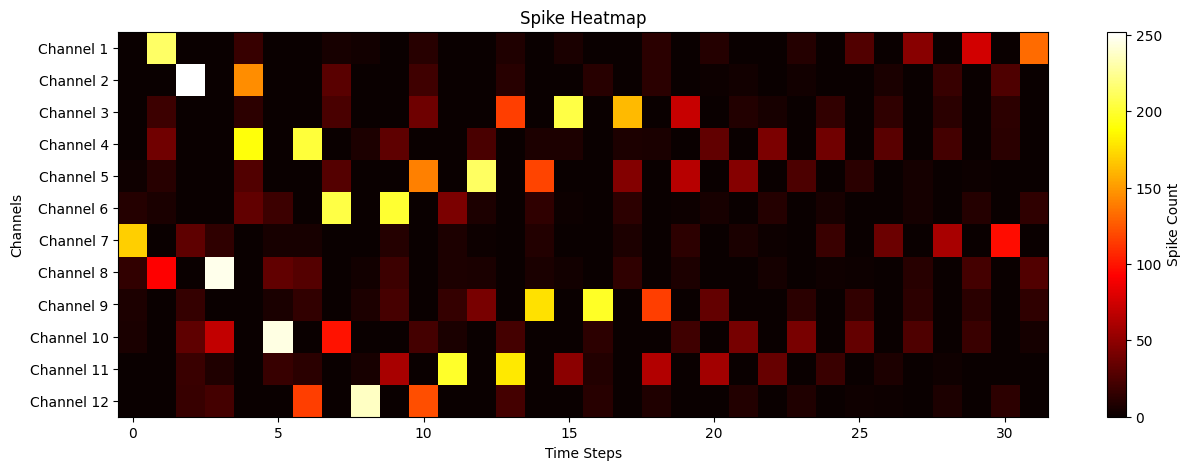

In [36]:
plt.figure(figsize=(15, 5))
plt.imshow(spikes[train_mask][0].cpu().numpy(), aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Spike Count')
plt.xlabel('Time Steps')
plt.ylabel('Channels')
plt.title('Spike Heatmap')
plt.yticks(range(spikes.size(1)), [f'Channel {i+1}' for i in range(spikes.size(1))])
plt.show()

In [37]:
loader = DataLoader(TensorDataset(spikes[train_mask & subject_masks[7]], classes[train_mask & subject_masks[7]]), batch_size=batch_size, collate_fn=collate, shuffle=True)
valid_loader = DataLoader(TensorDataset(spikes[valid_mask & subject_masks[7]], classes[valid_mask & subject_masks[7]]), batch_size=batch_size, collate_fn=collate, shuffle=True)
test_loader = DataLoader(TensorDataset(spikes[test_mask & subject_masks[7]], classes[test_mask & subject_masks[7]]), batch_size=batch_size, collate_fn=collate, shuffle=True)

In [38]:
len(loader), len(valid_loader), len(test_loader)

(13, 1, 2)

In [39]:
(subject_masks[7] & mask).sum().item()

218

In [40]:
class LifParClassifier(torch.nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 layers=2,
                 gain=None,
                 bias=None,
                 learn_beta=False,
                 learn_threshold=False,
                 spike_grad=snntorch.surrogate.fast_sigmoid()):
        super().__init__()
        sizes = [(input_size, hidden_size)] + [(hidden_size, hidden_size)] * (layers-2) + [(hidden_size, output_size)]
        self.lifs = torch.nn.ModuleList(
            [snntorch.LeakyParallel(in_size,
                                    out_size,
                                    learn_threshold=learn_threshold,
                                    learn_beta=learn_beta,
                                    spike_grad=spike_grad) for in_size, out_size in sizes])

        for name, param in self.named_parameters():
            if gain is not None and 'weight' in name:
                torch.nn.init.xavier_normal_(param, gain=gain)
            elif bias is not None and 'bias' in name:
                torch.nn.init.constant_(param, bias)
            
    def forward(self, x):
        for lif in self.lifs:
            x = lif(x)             
        return x


In [41]:
# Courtesy of o1.
def add_undecided(logits, dim=1):
    """
    Adds an extra column to the logits tensor. The column has a value of 1
    for rows where all values are equal, and 0 otherwise.

    The rationale being that maxargs on non firing neurons returns 0. Making it its
    own category makes the loss more straight forward. No trial should have this result.

    Args:
        logits (torch.Tensor): Input tensor of logits.
        dim (int): Dimension along which to check equality.

    Returns:
        torch.Tensor: Logits tensor with an additional column.
    """
    all_equal = (torch.diff(logits, dim=dim) == 0).all(dim=dim, keepdim=True)
    undecided_column = all_equal.float()
    return torch.cat([logits, undecided_column], dim=dim)

In [42]:
subject_epics = collections.defaultdict(list)
for subject in range(subjects_count):
    for run in range(runs):
        # Applies the masks for training and validation plus the mask for the subject
        # on the spikes and classes (labels). Done for each run for each subject.
        # Use a sampler to fight class imbalance optimizing for single class output.
        indices = train_mask & subject_masks[subject]
        class_weights = 1.0 / (torch.bincount(classes[indices]) + 1e-6)
        sample_weights = class_weights[classes[indices]]
        sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        
        loader = DataLoader(
            TensorDataset(spikes[indices], classes[indices]),
            batch_size=batch_size,
            collate_fn=collate,
            sampler=sampler
        )
        valid_loader = DataLoader(
            TensorDataset(spikes[valid_mask & subject_masks[subject]],
                          classes[valid_mask & subject_masks[subject]]),
            batch_size=batch_size,
            collate_fn=collate,
            shuffle=True)
        # Define the architecture 
        net = LifParClassifier(input_size=spikes.size(1),
                               hidden_size=hidden_size,
                               output_size=5,
                               layers=layers,
                               gain=gain,
                               bias=bias,
                               learn_threshold=True,
                               learn_beta=True
                              ).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        #criterion = snntorch.functional.ce_rate_loss()
        criterion = snntorch.functional.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
        # Plain vanilla training loop
        losses = []
        valid_losses = []
        progress = tqdm.tqdm(range(epochs), unit="epoch")
        for epoch in progress:
            batch_losses = []
            net.train()    
            for events, targets in loader:
                optimizer.zero_grad()
                spk = net(events)
                # Sum the timesteps of the spikes and add an extra class (label) if  
                # the number spikes for all classes were the same e.g. (0, 0, 0, 0, 0,) => class 5
                #logits = add_undecided(spk.sum(dim=0))
                logits = spk
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                batch_losses += [loss.item()]
            losses += [mean(batch_losses)]
        
            valid_batch_losses = []
            net.eval()
            with torch.no_grad():
                for events, targets in valid_loader:
                    spk = net(events)
                    #logits = add_undecided(spk.sum(dim=0))
                    logits = spk
                    loss = criterion(logits, targets)
                    valid_batch_losses += [loss.item()]
                    
            valid_losses += [mean(valid_batch_losses)]

            # If the last epoch has the least loss, save it for later.
            if valid_losses[-1] == min(valid_losses):
                epic = net
            
            progress.set_description(f'Subject: {subject} Run: {run} Loss: {losses[-1]:.4f} Val Loss: {valid_losses[-1]:.4f},')
        subject_epics[subject] += [epic]

Subject: 9 Run: 4 Loss: 1.6413 Val Loss: 2.0139,: 100%|██████████| 100/100 [00:12<00:00,  8.21epoch/s]
Subject: 10 Run: 0 Loss: 1.7344 Val Loss: 1.9077,: 100%|██████████| 100/100 [00:13<00:00,  7.35epoch/s]
Subject: 10 Run: 1 Loss: 1.5629 Val Loss: 1.9546,: 100%|██████████| 100/100 [00:13<00:00,  7.38epoch/s]
Subject: 10 Run: 2 Loss: 1.5408 Val Loss: 1.9054,: 100%|██████████| 100/100 [00:14<00:00,  7.11epoch/s]
Subject: 10 Run: 3 Loss: 1.5124 Val Loss: 1.9434,: 100%|██████████| 100/100 [00:13<00:00,  7.43epoch/s]
Subject: 10 Run: 4 Loss: 1.6944 Val Loss: 2.0161,: 100%|██████████| 100/100 [00:12<00:00,  7.96epoch/s]
Subject: 11 Run: 0 Loss: 1.7580 Val Loss: 1.7202,: 100%|██████████| 100/100 [00:14<00:00,  7.10epoch/s]
Subject: 11 Run: 1 Loss: 1.7646 Val Loss: 2.7348,: 100%|██████████| 100/100 [00:14<00:00,  7.07epoch/s]
Subject: 11 Run: 2 Loss: 1.6230 Val Loss: 2.3542,: 100%|██████████| 100/100 [00:13<00:00,  7.43epoch/s]
Subject: 11 Run: 3 Loss: 1.8374 Val Loss: 1.8585,: 100%|█████████

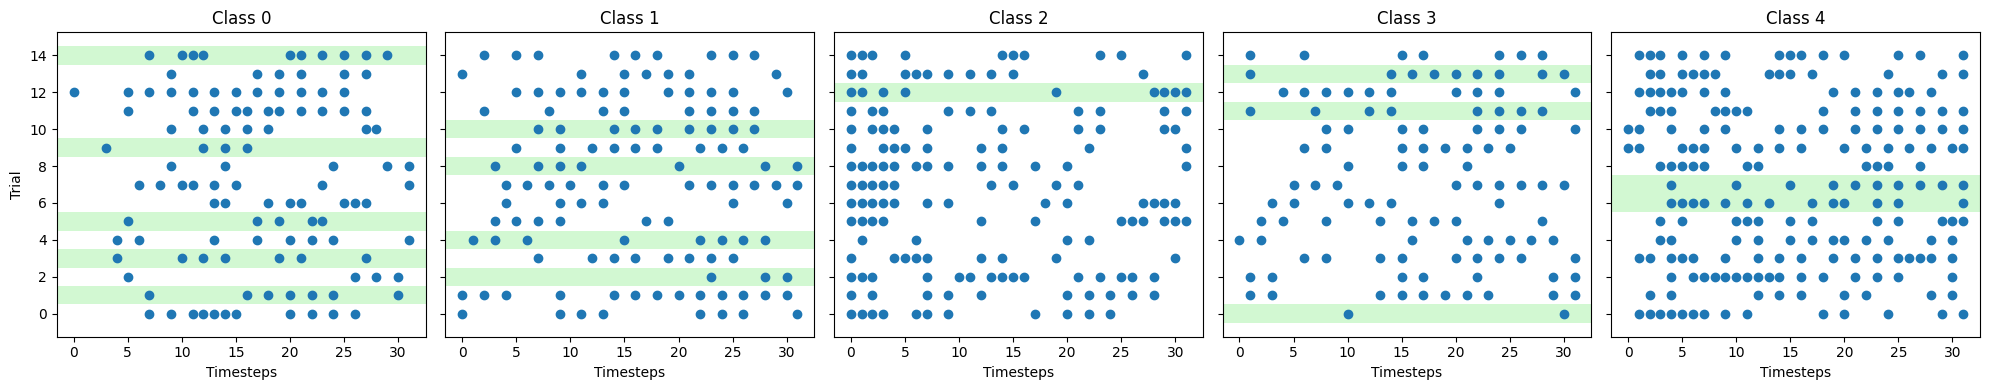

In [54]:
w = iter(valid_loader)
events, targets = next(w)
x = net(events).cpu().detach()

fig, axes = plt.subplots(1, n_classes, figsize=(4 * x.shape[2], 4), sharey=True)

for cls in range(n_classes):
    ax = axes[cls]
    
    for trial_idx in range(x.shape[1]):
        if targets[trial_idx] == cls:
            ax.axhspan(trial_idx - 0.5, trial_idx + 0.5, facecolor='lightgreen', alpha=0.4)
    
    splt.raster(x[:, :, cls], ax=ax)
    
    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Timesteps")
    if cls == 0:
        ax.set_ylabel("Trial")

plt.tight_layout()
plt.show()

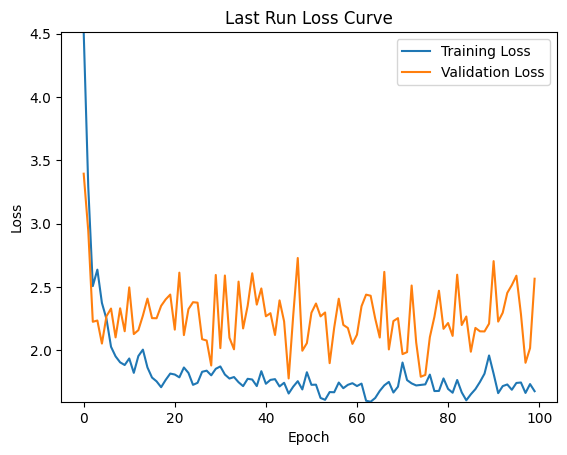

In [55]:
plt.figure()
plt.plot(losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Last Run Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(min(losses + valid_losses), min(max(losses + valid_losses), 10))
plt.legend()
plt.show()

Accuaracy M: 0.20644453673868826 SD: 0.08519553187606602


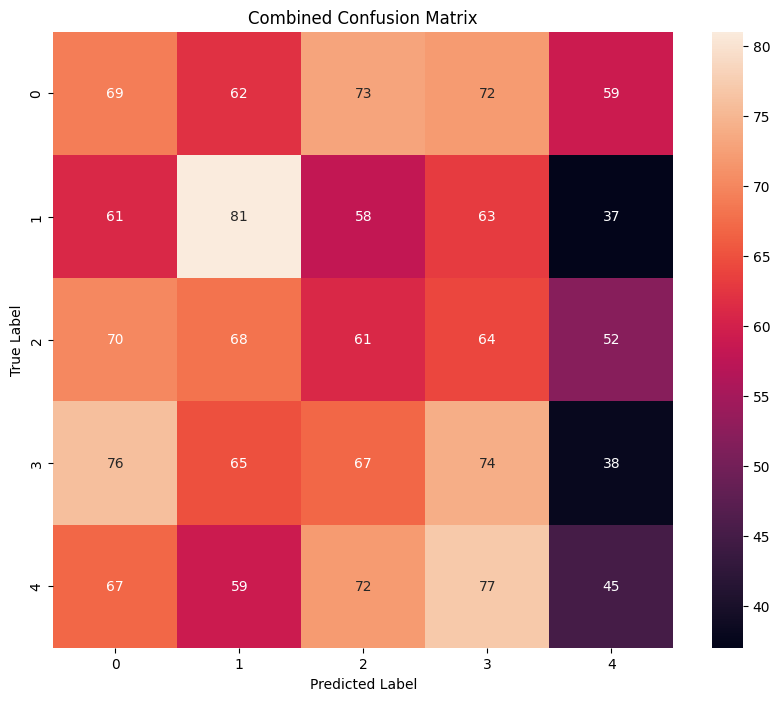

In [57]:
scores = []
for subject in range(subjects_count):
    for net in subject_epics[subject]:
        valid_loader = DataLoader(TensorDataset(spikes[valid_mask & subject_masks[subject]],
                                                classes[valid_mask & subject_masks[subject]]),
                                  batch_size=batch_size, collate_fn=collate, shuffle=True)
        net.eval()
        valid_predictions = []
        valid_targets = []
        with torch.no_grad():
            for events, targets in valid_loader:
                spk = net(events)
                logits = add_undecided(spk.sum(dim=0))
                predictions = torch.argmax(logits, dim=1)
                valid_predictions += predictions.tolist()
                valid_targets += targets.tolist()
        scores += [(valid_targets, valid_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuaracy M: 0.2035520392903172 SD: 0.08599844867417


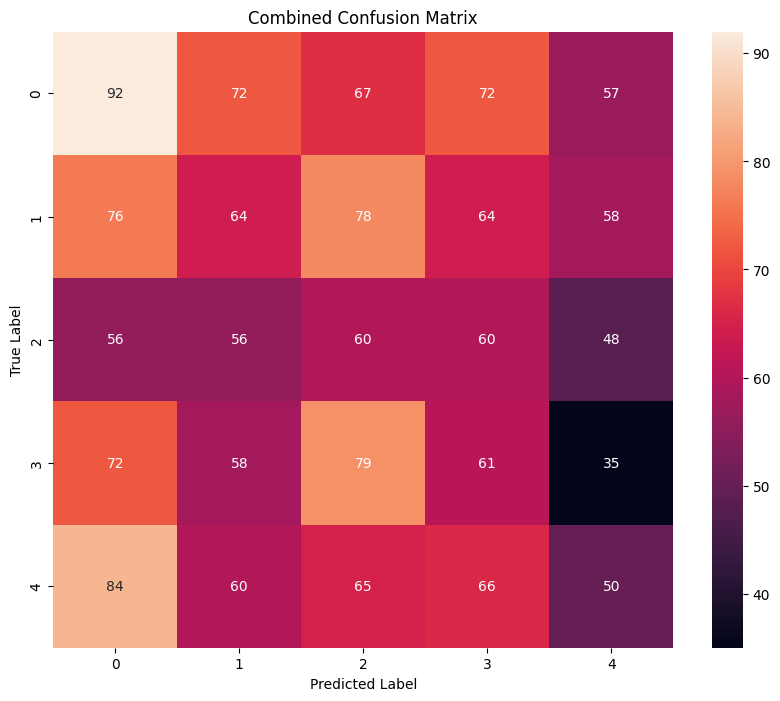

In [58]:
scores = []
for subject in range(subjects_count):
    for net in subject_epics[subject]:
        test_loader = DataLoader(TensorDataset(spikes[test_mask & subject_masks[subject]],
                                                classes[test_mask & subject_masks[subject]]),
                                  batch_size=batch_size, collate_fn=collate, shuffle=True)
        net.eval()
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for events, targets in test_loader:
                spk = net(events)
                logits = add_undecided(spk.sum(dim=0))
                predictions = torch.argmax(logits, dim=1)
                test_predictions += predictions.tolist()
                test_targets += targets.tolist()
        scores += [(test_targets, test_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
def bootstrap_indicies_from_mask(x):
    '''Sorted sampling of the mask with replacement.
    Input is boolean and mask output are indicies.'''
    indicies = torch.arange(len(x), device=x.device)[x]
    drawn_indicies = indicies[torch.randint(0, len(indicies), indicies.shape)]
    return torch.sort(drawn_indicies).values

class VoteEnsemble(torch.nn.Module):
    def __init__(self, classifiers):
        super().__init__()
        self.classifiers = classifiers

    def forward(self, x):
        logits = [classifier(x).sum(dim=0) for classifier in self.classifiers]
        logits = torch.stack(logits, dim=1)
        predicted_classes = logits.argmax(dim=-1)
        return torch.mode(predicted_classes, dim=1).values


In [63]:
subject_epics = collections.defaultdict(list)
for subject in range(subjects_count):
    for run in range(runs):
        # Applies the training and validation masks along with the subject mask on the spikes and classes (labels).
        # Performs bootstrapping to generate indices and uses a weighted random sampler to address class imbalance.
        # This setup is done for each run and each subject.
        indices = bootstrap_indicies_from_mask(train_mask & subject_masks[subject])        
        class_weights = 1.0 / (torch.bincount(classes[indices]) + 1e-6)
        sample_weights = class_weights[classes[indices]]
        sampler = torch.utils.data.WeightedRandomSampler(
            sample_weights, 
            num_samples=len(sample_weights), 
            replacement=True
        )
        loader = DataLoader(
            TensorDataset(spikes[indices], classes[indices]),
            batch_size=batch_size,
            collate_fn=collate,
            sampler=sampler
        )
        valid_loader = DataLoader(
            TensorDataset(spikes[valid_mask & subject_masks[subject]],
                          classes[valid_mask & subject_masks[subject]]),
            batch_size=batch_size,
            collate_fn=collate,
            shuffle=True)
        # Define the architecture 
        net = LifParClassifier(input_size=spikes.size(1),
                               hidden_size=hidden_size,
                               output_size=5,
                               layers=layers,
                               gain=gain,
                               bias=bias,
                               learn_threshold=True,
                               learn_beta=True
                              ).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        #criterion = snntorch.functional.ce_rate_loss()
        criterion = snntorch.functional.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

        # Plain vanilla training loop
        losses = []
        valid_losses = []
        progress = tqdm.tqdm(range(epochs), unit="epoch")
        for epoch in progress:
            batch_losses = []
            net.train()    
            for events, targets in loader:
                optimizer.zero_grad()
                spk = net(events)
                # Sum the timesteps of the spikes and add an extra class (label) if  
                # the number spikes for all classes were the same e.g. (0, 0, 0, 0, 0,) => class 5
                #logits = add_undecided(spk.sum(dim=0))
                logits = spk
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                batch_losses += [loss.item()]
            losses += [mean(batch_losses)]
        
            valid_batch_losses = []
            net.eval()
            with torch.no_grad():
                for events, targets in valid_loader:
                    spk = net(events)
                    #logits = add_undecided(spk.sum(dim=0))
                    logits = spk
                    loss = criterion(logits, targets)
                    valid_batch_losses += [loss.item()]
                    
            valid_losses += [mean(valid_batch_losses)]

            # If the last epoch has the least loss, save it for later.
            if valid_losses[-1] == min(valid_losses):
                epic = net
            
            progress.set_description(f'Subject: {subject} Run: {run} Loss: {losses[-1]:.4f} Val Loss: {valid_losses[-1]:.4f},')
        subject_epics[subject] += [epic]
    subject_epics[subject] = [VoteEnsemble(subject_epics[subject])]

Subject: 9 Run: 4 Loss: 1.0452 Val Loss: 2.0497,: 100%|██████████| 100/100 [00:12<00:00,  7.89epoch/s]
Subject: 10 Run: 0 Loss: 1.4873 Val Loss: 2.0160,: 100%|██████████| 100/100 [00:13<00:00,  7.67epoch/s]
Subject: 10 Run: 1 Loss: 1.1918 Val Loss: 2.0531,: 100%|██████████| 100/100 [00:12<00:00,  7.96epoch/s]
Subject: 10 Run: 2 Loss: 1.2590 Val Loss: 1.9678,: 100%|██████████| 100/100 [00:12<00:00,  7.73epoch/s]
Subject: 10 Run: 3 Loss: 1.1695 Val Loss: 2.0618,: 100%|██████████| 100/100 [00:12<00:00,  7.71epoch/s]
Subject: 10 Run: 4 Loss: 1.2991 Val Loss: 2.1479,: 100%|██████████| 100/100 [00:12<00:00,  7.86epoch/s]
Subject: 11 Run: 0 Loss: 1.6724 Val Loss: 2.0876,: 100%|██████████| 100/100 [00:14<00:00,  6.85epoch/s]
Subject: 11 Run: 1 Loss: 1.0825 Val Loss: 2.2072,: 100%|██████████| 100/100 [00:14<00:00,  6.72epoch/s]
Subject: 11 Run: 2 Loss: 1.2409 Val Loss: 1.8694,: 100%|██████████| 100/100 [00:14<00:00,  6.68epoch/s]
Subject: 11 Run: 3 Loss: 1.1793 Val Loss: 1.9242,: 100%|█████████

In [73]:
net(events)

tensor([2, 3, 1, 4, 2, 4, 1, 0, 1, 0, 4, 1, 3, 4, 0], device='cuda:0')

Accuaracy M: 0.20472047494059553 SD: 0.08086832229930582


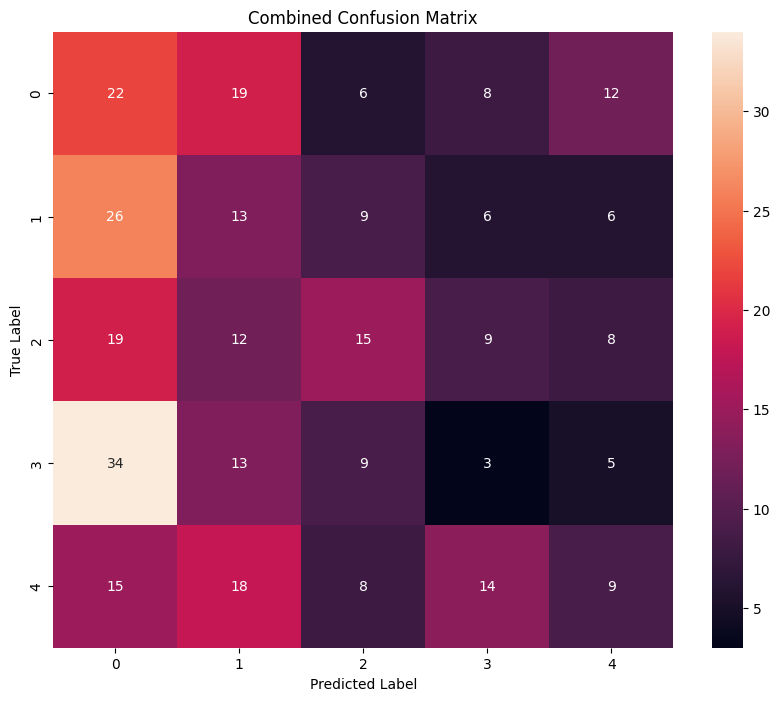

In [74]:
scores = []
for subject in range(subjects_count):
    for net in subject_epics[subject]:
        valid_loader = DataLoader(TensorDataset(spikes[valid_mask & subject_masks[subject]],
                                                classes[valid_mask & subject_masks[subject]]),
                                  batch_size=batch_size, collate_fn=collate, shuffle=True)
        net.eval()
        valid_predictions = []
        valid_targets = []
        with torch.no_grad():
            for events, targets in valid_loader:
                predictions = net(events)
                valid_predictions += predictions.tolist()
                valid_targets += targets.tolist()
        scores += [(valid_targets, valid_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuaracy M: 0.17296972280348238 SD: 0.09214127734688736


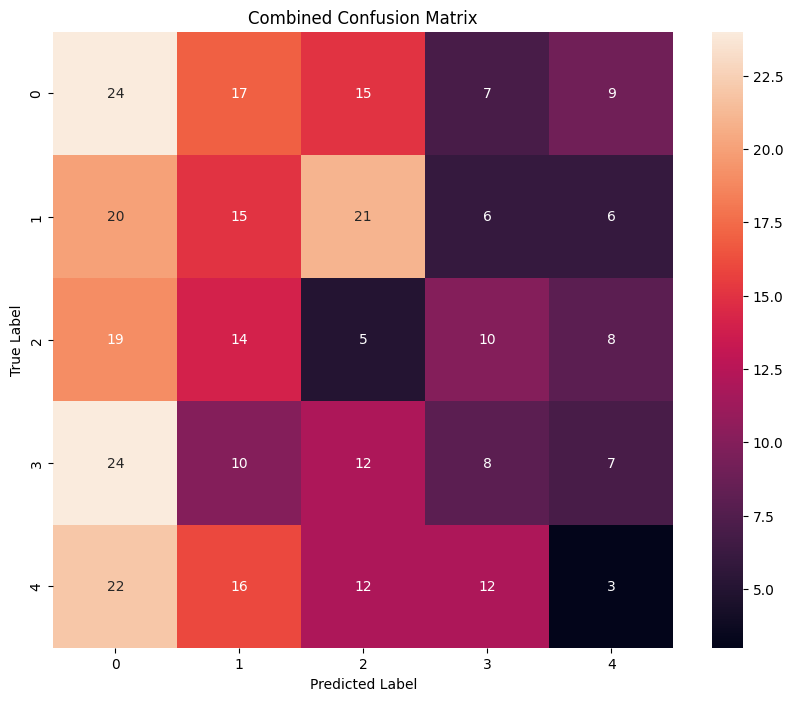

In [75]:
scores = []
for subject in range(subjects_count):
    for net in subject_epics[subject]:
        test_loader = DataLoader(TensorDataset(spikes[test_mask & subject_masks[subject]],
                                                classes[test_mask & subject_masks[subject]]),
                                  batch_size=batch_size, collate_fn=collate, shuffle=True)
        net.eval()
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for events, targets in test_loader:
                predictions = net(events)
                test_predictions += predictions.tolist()
                test_targets += targets.tolist()
        scores += [(test_targets, test_predictions)]

accuracies = [accuracy_score(*score) for score in scores]
print("Accuaracy M:", mean(accuracies), "SD:", stdev(accuracies))

cm = confusion_matrix(*(sum(lst, []) for lst in zip(*scores)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()